<h2> Doing quantization and getting overall metric for all the models </h2>

In [ ]:
import tensorflow as tf
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import gc
gc.collect()
import cv2
import tensorflow as tf
import keras
from PIL import Image, ImageDraw
from PIL import ImagePath
import imgaug.augmenters as iaa
from skimage import exposure
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform, he_normal
from tensorflow.keras.losses import binary_crossentropy
import pathlib
K.set_image_data_format('channels_last')

In [ ]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


In [ ]:
#https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
def getInfoDICOM(path, data_rle_train, toPrint = False, train = True):

    info = {}

    path = os.path.join(path)
    #reading the data using methods of pydicom
    data = pydicom.dcmread(path)
    info['path'] = path
    info['age'] = data.PatientAge
    info['sex']= data.PatientSex
    info['ImageId'] = data.SOPInstanceUID
    
    if train: #test doesn't have encoded pixels data, we have to predict them
        #SOPInstanceUID contains the storage type which resembles the image ids given in train-rle dataset
        encodedPixels = data_rle_train[data_rle_train['ImageId'] == data.SOPInstanceUID]["EncodedPixels"].values
        info['encodedPixels'] = encodedPixels

        info['lenOfEncodedPixels'] = len(encodedPixels)

        #this is for visualization purpose
        if '-1' in encodedPixels or len(encodedPixels) == 0:
            info['has_pneumothorax'] = 0 
        else:
            info['has_pneumothorax'] = 1
    
    if toPrint:
        print("Path...............:", path)
        print("Patient's Name.....:", data.PatientName)
        print("Patient's Id.......:", data.PatientID)
        print("Patient's Age......:", data.PatientAge)
        print("Patient's Sex......:", data.PatientSex)

        print("Original X Ray")
        plt.figure(figsize=(10,10))
        plt.imshow(data.pixel_array, cmap=plt.cm.bone)
        plt.show()


    return info

In [ ]:
def computeMasks(train, path):
    mask_paths = []
    for index, row in train.iterrows():
        pixels = row['encodedPixels']
        mask = np.zeros((1024, 1024))
        if row['has_pneumothorax'] == 1:          
            for pix in pixels:
                mask = mask + rle2mask(pix, 1024, 1024).T       
        img = Image.fromarray(mask).convert('L')
        path2save = path + str(index+1) + ".jpg"
        img.save(path2save)
        mask_paths.append(path2save)
    train["mask"] = mask_paths
    return train

In [ ]:
def convertImagesToJpeg(train, path):
    images_paths = []
    for index, row in train.iterrows():
        path2dicom = row['path']
        ds = pydicom.read_file(path2dicom) # read dicom image
        img = ds.pixel_array # get image array
        img_mem = Image.fromarray(img) # Creates an image memory from an object exporting the array interface
        path2save = path + str(index + 1)  + ".jpg"
        img_mem.save(path2save)
        images_paths.append(path2save)
    train["images_paths"] = images_paths
    return train

In [ ]:
img_size = 256

In [ ]:
def load_data():
    print("Loading Data ...")
    data_rle_train = pd.read_csv("./siim/train-rle.csv")
    #The second column contains a space infront of it so manually rewriting it
    data_rle_train.columns = ['ImageId', 'EncodedPixels']

    print("Extracting info from dicom")
    filesList = glob.glob('./siim/dicom-images-train/*/*/*.dcm')
    train = pd.DataFrame()
    train_list = []
    for file in filesList:
        info = getInfoDICOM(file, data_rle_train, False, True)
        if info['has_pneumothorax'] == 1:         
            train_list.append(info)
    train = pd.DataFrame(train_list)
    train.loc[train.lenOfEncodedPixels == 0 , 'encodedPixels'] = np.array(-1)
    print("Extracted info from dicom")

    print("Computing Masks")
    path = "siim/dicom-mask-train/"
    try:
        os.makedirs(path)
    except:
        pass
    train = computeMasks(train, path)
    print("Computed Masks")

    print("Converting Images to Jpg")
    path = "siim/dicom-images-train-jpg/"
    try:
        os.makedirs(path)
    except:
        pass
    train = convertImagesToJpeg(train, path)
    print("Converted Images to Jpg")

    return train

In [ ]:
threshold = 0.38 #learned from previous model
train = load_data()

Loading Data ...
Extracting info from dicom
Extracted info from dicom
Computing Masks
Computed Masks
Converting Images to Jpg
Converted Images to Jpg


In [ ]:
train.head()

,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask,images_paths
0,./siim/dicom-images-train/1.2.276.0.7230010.3....,26,M,1.2.276.0.7230010.3.1.4.8323329.1051.151787516...,[120571 17 997 37 977 52 967 62 957 72 947 79 ...,1,1,siim/dicom-mask-train/1.jpg,siim/dicom-images-train-jpg/1.jpg
1,./siim/dicom-images-train/1.2.276.0.7230010.3....,16,M,1.2.276.0.7230010.3.1.4.8323329.4168.151787518...,[166327 32 980 103 918 120 901 127 893 135 882...,1,1,siim/dicom-mask-train/2.jpg,siim/dicom-images-train-jpg/2.jpg
2,./siim/dicom-images-train/1.2.276.0.7230010.3....,63,F,1.2.276.0.7230010.3.1.4.8323329.5057.151787518...,[672226 6 1017 8 1014 11 1012 13 1010 14 1010 ...,3,1,siim/dicom-mask-train/3.jpg,siim/dicom-images-train-jpg/3.jpg
3,./siim/dicom-images-train/1.2.276.0.7230010.3....,13,F,1.2.276.0.7230010.3.1.4.8323329.3444.151787517...,[175365 13 1009 21 1002 23 999 27 72 1 921 31 ...,2,1,siim/dicom-mask-train/4.jpg,siim/dicom-images-train-jpg/4.jpg
4,./siim/dicom-images-train/1.2.276.0.7230010.3....,51,F,1.2.276.0.7230010.3.1.4.8323329.1478.151787516...,[268739 3 986 45 964 65 954 75 944 84 935 91 9...,3,1,siim/dicom-mask-train/5.jpg,siim/dicom-images-train-jpg/5.jpg


In [ ]:
smooth = 1e-5
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
def combined_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred) + binary_crossentropy(y_true, y_pred)

In [ ]:
!unzip pneumothorax_predictor.zip

Archive:  pneumothorax_predictor.zip
   creating: pneumothorax_predictor/pneumothorax_predictor/
   creating: pneumothorax_predictor/pneumothorax_predictor/assets/
  inflating: pneumothorax_predictor/pneumothorax_predictor/saved_model.pb  
   creating: pneumothorax_predictor/pneumothorax_predictor/variables/
  inflating: pneumothorax_predictor/pneumothorax_predictor/variables/variables.data-00000-of-00001  
  inflating: pneumothorax_predictor/pneumothorax_predictor/variables/variables.index  


In [ ]:
pneumothorax_predictor = tf.keras.models.load_model("pneumothorax_predictor/pneumothorax_predictor", custom_objects={'dice_coef' : dice_coef, 'combined_loss': combined_loss})

In [ ]:
#Predictor
converter_pred = tf.lite.TFLiteConverter.from_keras_model(pneumothorax_predictor)
tflite_models_dir = pathlib.Path("/content/pneumothorax/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
converter_pred.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_predict_model = converter_pred.convert()
tflite_model_quant_file = tflite_models_dir/"predictor.tflite"
tflite_model_quant_file.write_bytes(tflite_predict_model)

INFO:tensorflow:Assets written to: /tmp/tmpvjcj690u/assets


INFO:tensorflow:Assets written to: /tmp/tmpvjcj690u/assets


7588272

In [ ]:
interpreter_predictor = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_predictor.allocate_tensors()

In [ ]:
!unzip pneumothorax_classifier.zip

Archive:  pneumothorax_classifier.zip
   creating: pneumothorax_classifier/assets/
  inflating: pneumothorax_classifier/saved_model.pb  
   creating: pneumothorax_classifier/variables/
  inflating: pneumothorax_classifier/variables/variables.data-00000-of-00001  
  inflating: pneumothorax_classifier/variables/variables.index  


In [ ]:
pneumothorax_classifier = tf.keras.models.load_model("pneumothorax_classifier")

In [ ]:
#Classifer
converter_class = tf.lite.TFLiteConverter.from_keras_model(pneumothorax_classifier)
tflite_models_dir = pathlib.Path("/content/pneumothorax/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
converter_class.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_classifier_model = converter_class.convert()
tflite_model_quant_file = tflite_models_dir/"classifier.tflite"
tflite_model_quant_file.write_bytes(tflite_classifier_model)

INFO:tensorflow:Assets written to: /tmp/tmp1_l3891a/assets


INFO:tensorflow:Assets written to: /tmp/tmp1_l3891a/assets


6796272

In [ ]:
interpreter_classifer = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_classifer.allocate_tensors()

In [ ]:
!unzip pneumothorax_classifier_oversampling.zip

Archive:  pneumothorax_classifier_oversampling.zip
   creating: pneumothorax_classifier_oversampling/assets/
  inflating: pneumothorax_classifier_oversampling/saved_model.pb  
   creating: pneumothorax_classifier_oversampling/variables/
  inflating: pneumothorax_classifier_oversampling/variables/variables.data-00000-of-00001  
  inflating: pneumothorax_classifier_oversampling/variables/variables.index  


In [ ]:
pneumothorax_classifier_oversampling = tf.keras.models.load_model("pneumothorax_classifier_oversampling")

In [ ]:
#Classifer_Oversampled
converter_class_oversampled = tf.lite.TFLiteConverter.from_keras_model(pneumothorax_classifier_oversampling)
tflite_models_dir = pathlib.Path("/content/pneumothorax/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
converter_class.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_classifier_model = converter_class_oversampled.convert()
tflite_model_quant_file = tflite_models_dir/"classifier_over.tflite"
tflite_model_quant_file.write_bytes(tflite_classifier_model)

INFO:tensorflow:Assets written to: /tmp/tmpghslbavs/assets


INFO:tensorflow:Assets written to: /tmp/tmpghslbavs/assets


26403360

In [ ]:
interpreter_classifer_oversampled = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_classifer_oversampled.allocate_tensors()

In [ ]:
#Sampling 200 images because of resource constraints
train_sampled = train.sample(200)

In [ ]:
#Getting the overall metric of model non - oversampled
dice_coef_avg = 0
for index in tqdm(range(len(train_sampled))):
    image = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction

    mask = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['mask'], color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask, dtype = 'float32')
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = mask / 255.0
    
    image = tf.expand_dims(image, axis = 0)

    is_pneumothorax = pneumothorax_classifier.predict(image) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        pred_masks = pneumothorax_predictor.predict(image) 
        pred_masks = pred_masks[0]
    else :
        pred_masks = np.zeros((256,256,1))
    
    dice_coef_avg  = dice_coef_avg +  dice_coef(mask, pred_masks)

100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


In [ ]:
print("Average dice coef for non - oversampled model is:", dice_coef_avg.numpy()/200)

Average dice coef for non - oversampled model is: 0.11101271629333496


In [ ]:
#Getting the overall metric of quantized model non - oversampled
dice_coef_avg = 0
for index in tqdm(range(len(train_sampled))):
    image = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction

    mask = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['mask'], color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask, dtype = 'float32')
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = mask / 255.0
    
    image = tf.expand_dims(image, axis = 0)

    input_index = interpreter_classifer.get_input_details()[0]["index"]
    output_index = interpreter_classifer.get_output_details()[0]["index"]
    interpreter_classifer.set_tensor(input_index, image)
    interpreter_classifer.invoke()
    is_pneumothorax = interpreter_classifer.get_tensor(output_index) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        input_index = interpreter_predictor.get_input_details()[0]["index"]
        output_index = interpreter_predictor.get_output_details()[0]["index"]
        interpreter_predictor.set_tensor(input_index, image)
        interpreter_predictor.invoke()
        pred_masks = tf.reshape(interpreter_predictor.get_tensor(output_index), [256, 256, 1])
        
    else :
        pred_masks = np.zeros((256,256,1))
    
    dice_coef_avg  = dice_coef_avg +  dice_coef(mask, pred_masks)

100%|██████████| 200/200 [44:39<00:00, 13.40s/it]


In [ ]:
print("Average dice coef for quantized non - oversampled model is:", dice_coef_avg.numpy()/200)

Average dice coef for quantized non - oversampled model is: 0.07591805458068848


In [ ]:
#Getting the overall metric of model oversampled
dice_coef_avg = 0
for index in tqdm(range(len(train_sampled))):
    image = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction

    mask = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['mask'], color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask, dtype = 'float32')
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = mask / 255.0
    
    image = tf.expand_dims(image, axis = 0)

    is_pneumothorax = pneumothorax_classifier_oversampling.predict(image) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        pred_masks = pneumothorax_predictor.predict(image) 
        pred_masks = pred_masks[0]
    else :
        pred_masks = np.zeros((256,256,1))
    
    dice_coef_avg  = dice_coef_avg +  dice_coef(mask, pred_masks)

100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


In [ ]:
print("Average dice coef for oversampled model is:", dice_coef_avg.numpy()/200)

Average dice coef for oversampled model is: 0.142722749710083


In [ ]:
#Getting the overall metric of quantized model oversampled
dice_coef_avg = 0
for index in tqdm(range(len(train_sampled))):
    image = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction

    mask = tf.keras.preprocessing.image.load_img(train_sampled.iloc[index]['mask'], color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask, dtype = 'float32')
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = mask / 255.0
    
    image = tf.expand_dims(image, axis = 0)

    input_index = interpreter_classifer_oversampled.get_input_details()[0]["index"]
    output_index = interpreter_classifer_oversampled.get_output_details()[0]["index"]
    interpreter_classifer_oversampled.set_tensor(input_index, image)
    interpreter_classifer_oversampled.invoke()
    is_pneumothorax = interpreter_classifer_oversampled.get_tensor(output_index) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        input_index = interpreter_predictor.get_input_details()[0]["index"]
        output_index = interpreter_predictor.get_output_details()[0]["index"]
        interpreter_predictor.set_tensor(input_index, image)
        interpreter_predictor.invoke()
        pred_masks = tf.reshape(interpreter_predictor.get_tensor(output_index), [256, 256, 1])
        
    else :
        pred_masks = np.zeros((256,256,1))
    
    dice_coef_avg  = dice_coef_avg +  dice_coef(mask, pred_masks)

100%|██████████| 200/200 [43:23<00:00, 13.02s/it]


In [ ]:
print("Average dice coef for quantized oversampled model is:", dice_coef_avg.numpy()/200)

Average dice coef for quantized oversampled model is: 0.09985686302185058


In [ ]:
def display(display_list):
    plt.figure(figsize=(25, 25))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Predicted Mask(Quantized)', 'Predicted Mask(Oversampled)', 'Predicted Mask(Oversampled - Quantized)']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
train_display = train.sample(5)

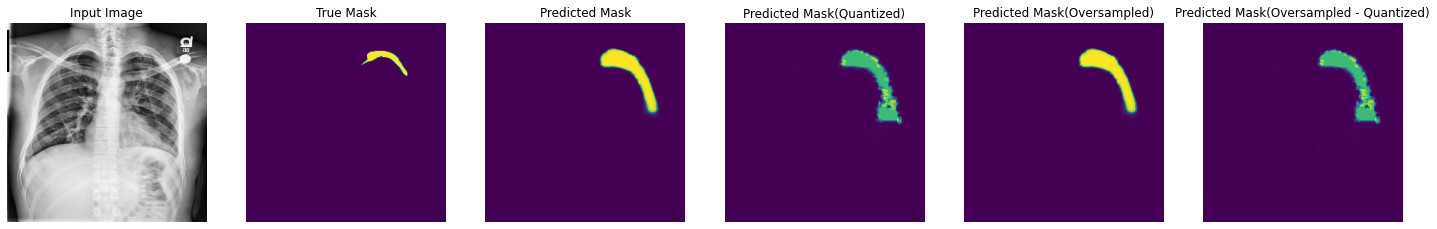

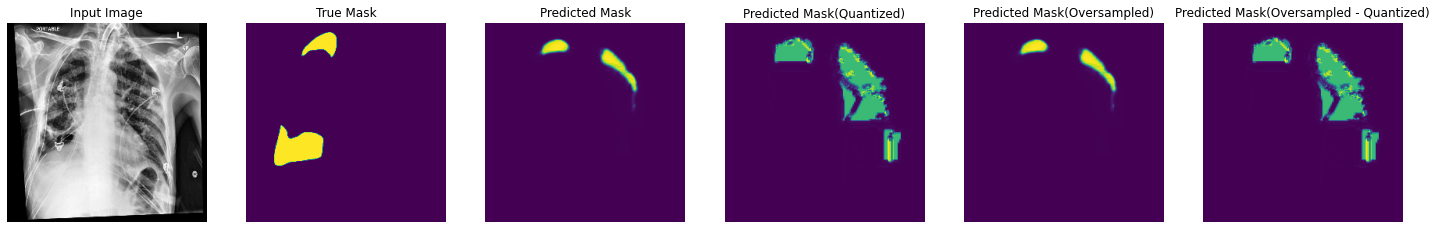

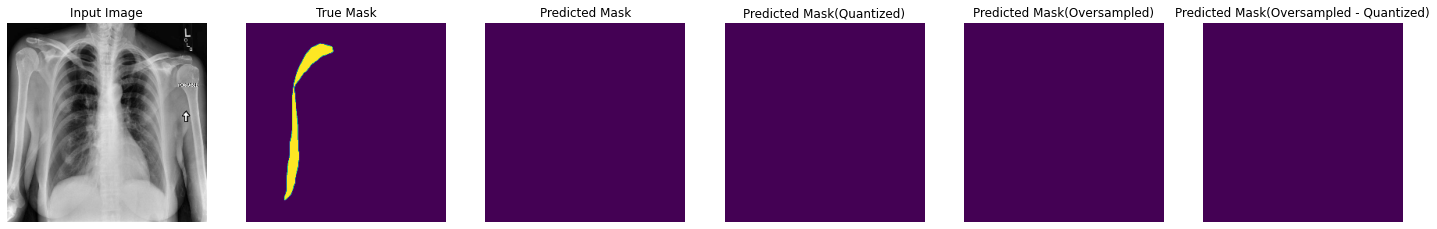

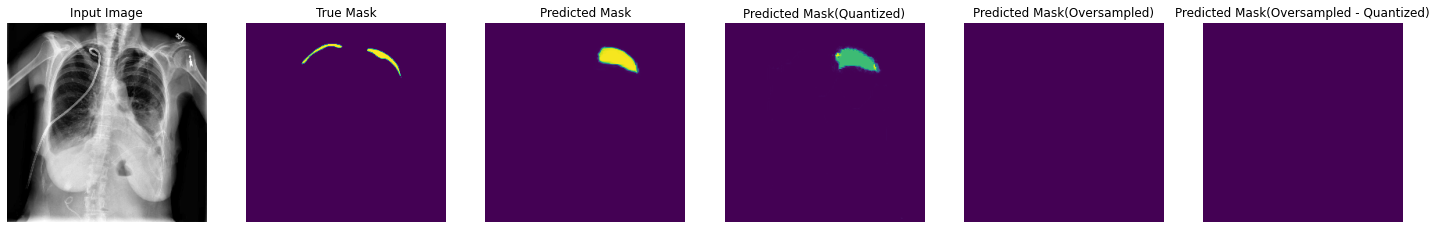

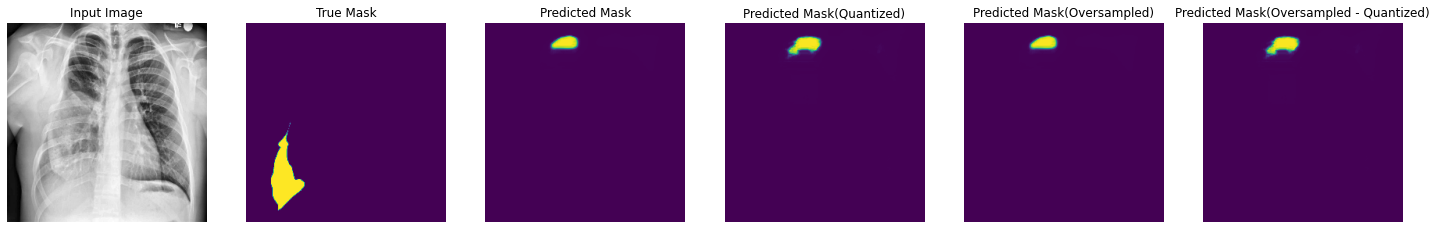

In [ ]:
for index in range(len(train_display)):
    image = tf.keras.preprocessing.image.load_img(train_display.iloc[index]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction

    mask = tf.keras.preprocessing.image.load_img(train_display.iloc[index]['mask'], color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask, dtype = 'float32')
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = mask / 255.0
    
    image = tf.expand_dims(image, axis = 0)

    #Non - Oversampled
    is_pneumothorax = pneumothorax_classifier(image) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        pred_masks = pneumothorax_predictor.predict(image)
        pred_masks = pred_masks[0]
    else :
        pred_masks = np.zeros((256,256,1))

    #Quantized
    input_index = interpreter_classifer.get_input_details()[0]["index"]
    output_index = interpreter_classifer.get_output_details()[0]["index"]
    interpreter_classifer.set_tensor(input_index, image)
    interpreter_classifer.invoke()
    is_pneumothorax = interpreter_classifer.get_tensor(output_index) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        input_index = interpreter_predictor.get_input_details()[0]["index"]
        output_index = interpreter_predictor.get_output_details()[0]["index"]
        interpreter_predictor.set_tensor(input_index, image)
        interpreter_predictor.invoke()
        pred_masks_quant = tf.reshape(interpreter_predictor.get_tensor(output_index), [256, 256, 1])   
    else :
        pred_masks_quant = np.zeros((256,256,1))

    #Oversampled
    is_pneumothorax = pneumothorax_classifier_oversampling(image) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        pred_masks_over = pneumothorax_predictor.predict(image)
        pred_masks_over = pred_masks_over[0]
    else :
        pred_masks_over = np.zeros((256,256,1))

    #Quantized Oversampled
    input_index = interpreter_classifer_oversampled.get_input_details()[0]["index"]
    output_index = interpreter_classifer_oversampled.get_output_details()[0]["index"]
    interpreter_classifer_oversampled.set_tensor(input_index, image)
    interpreter_classifer_oversampled.invoke()
    is_pneumothorax = interpreter_classifer_oversampled.get_tensor(output_index) 
    is_pneumothorax = is_pneumothorax[0]

    if is_pneumothorax >= threshold :
        input_index = interpreter_predictor.get_input_details()[0]["index"]
        output_index = interpreter_predictor.get_output_details()[0]["index"]
        interpreter_predictor.set_tensor(input_index, image)
        interpreter_predictor.invoke()
        pred_masks_quant_over = tf.reshape(interpreter_predictor.get_tensor(output_index), [256, 256, 1])     
    else :
        pred_masks_quant_over = np.zeros((256,256,1))
        
    display([image[0], mask, pred_masks, pred_masks_quant, pred_masks_over , pred_masks_quant_over])

-- Quantized models have reduced quality